In [1]:
import numpy as np
from matplotlib.pyplot import *
# %config InlineBackend.figure_format = 'retina'
# matplotlib.pyplot.style.use("dark_background")

import jax
from jax import random
from jax import numpy as jnp

# from colabtools import adhoc_import

from inference_gym import using_jax as gym

# from tensorflow_probability.spinoffs.fun_mc import using_jax as fun_mcmc
from fun_mc import using_jax as fun_mcmc


# import tensorflow as tf
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.internal import unnest


import tensorflow_probability as _tfp
tfp = _tfp.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

tfp_np = _tfp.substrates.numpy
tfd_np = tfp_np.distributions 

2024-05-23 11:52:27.875012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with open("utility.py") as f:
    exec(f.read())


In [3]:
import matplotlib.pyplot as plt

# set font size for matplot lib
font = {'family': 'normal',
        'weight': 'bold',
        'size': 20}

matplotlib.rc('font', **font)

# Allows figures to rend latex
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amsfonts}')


## Setup problem

In [5]:
problem_name = 'Bananas'

if (problem_name == 'Bananas'):
  target = gym.targets.VectorModel(gym.targets.Banana(),
                                    flatten_sample_transformations=True)
  num_dimensions = target.event_shape[0]  
  init_step_size = 1.

if (problem_name == 'GermanCredit'):
  # This problem seems to require that we load TF datasets first.
  import tensorflow_datasets
  target = gym.targets.VectorModel(gym.targets.GermanCreditNumericSparseLogisticRegression(),
                                    flatten_sample_transformations=True)
  num_dimensions = target.event_shape[0]
  init_step_size = 0.02

if (problem_name == 'Brownian'):
  target = gym.targets.BrownianMotionMissingMiddleObservations()
  target = gym.targets.VectorModel(target,
                                    flatten_sample_transformations = True)
  num_dimensions = target.event_shape[0]
  init_step_size = 0.01

def target_log_prob_fn(x):
  """Unnormalized, unconstrained target density.

  This is a thin wrapper that applies the default bijectors so that we can
  ignore any constraints.
  """
  y = target.default_event_space_bijector(x)
  fldj = target.default_event_space_bijector.forward_log_det_jacobian(x)
  return target.unnormalized_log_prob(y) + fldj

# NOTE: use a large factor to get overdispered initializations.
# NOTE: don't set offset to 0 when the target mean is 0.
# CHECK: what scale should we use? Poor inits can make the problem much more
# difficult.
# NOTE: we probably want inits that allow us to get decent estimates
# in the long regime

# if (problem_name == 'Bananas'):
if (problem_name == 'Bananas'):
  offset = 2
  def initialize (shape, key = random.PRNGKey(37272709)):
    return 3 * random.normal(key, shape + (num_dimensions,)) + offset

if (problem_name == 'GermanCredit'):
  offset = 0.1
  def initialize (shape, key = random.PRNGKey(37272709)):
    return 0.5 * random.normal(key, shape + (num_dimensions,)) + offset

def target_log_prob_fn(x):
  """Unnormalized, unconstrained target density.

  This is a thin wrapper that applies the default bijectors so that we can
  ignore any constraints.
  """
  y = target.default_event_space_bijector(x)
  fldj = target.default_event_space_bijector.forward_log_det_jacobian(x)
  return target.unnormalized_log_prob(y) + fldj

# NOTE: use a large factor to get overdispered initializations.
# NOTE: don't set offset to 0 when the target mean is 0.
# CHECK: what scale should we use? Poor inits can make the problem much more
# difficult.
# NOTE: we probably want inits that allow us to get decent estimates
# in the long regime

# if (problem_name == 'Bananas'):
if (problem_name == 'Bananas'):
  offset = 2
  def initialize (shape, key = random.PRNGKey(37272709)):
    return 3 * random.normal(key, shape + (num_dimensions,)) + offset

if (problem_name == 'GermanCredit'):
  offset = 0.1
  def initialize (shape, key = random.PRNGKey(37272709)):
    return 0.5 * random.normal(key, shape + (num_dimensions,)) + offset

In [12]:
# Transition kernel for long regime
num_chains_long = 4
if (problem_name == 'GermanCredit'):
  num_warmup_long, num_sampling_long = 500, 1000
if (problem_name == 'Bananas'):
  num_warmup_long, num_sampling_long = 100, 1000
total_samples_long = num_warmup_long + num_sampling_long

# CHECK: is this the transition kernel we want to use?
# REMARK: the step size is picked based on the model we're fitting
if (problem_name == 'Bananas' or problem_name == 'GermanCredit'):
  kernel_long = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
  kernel_long = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel_long, num_warmup_long)
  kernel_long = tfp.mcmc.DualAveragingStepSizeAdaptation(
      kernel_long, num_warmup_long, target_accept_prob = 0.75,
      reduce_fn=tfp.math.reduce_log_harmonic_mean_exp)

# Follow the inference gym tutorial
# NOTE: transition kernel below is untested.
if (problem_name == 'Brownian'):
  kernel_long = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
  # Adapt step size.
  kernel_long = tfp.mcmc.DualAveragingStepSizeAdaptation(
    kernel_long, num_warmup_long, # int(num_samples // 2 * 0.8),
    target_accept_prob = 0.9)
  # Adapt trajectory length.
  kernel_long = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(
    kernel_long,
    num_adaptation_steps = num_warmup_long)
  

initial_state = initialize((num_chains_long,))


In [13]:
result_long = tfp.mcmc.sample_chain(
  total_samples_long, initial_state, kernel = kernel_long, seed = random.PRNGKey(1954))

/mnt/home/cmargossian/Code/nested-rhat/virenv/nRhatVirenv/lib/python3.9/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [14]:
# Transition kernel for short regime
# CHECK: how many warmup iterations should we use here?
# Suggested options: 512, 1024, 2048, 2500
num_chains_short = 512
num_super_chains = 4

if (problem_name == 'GermanCredit'):
  num_warmup_short, num_sampling_short = 1000, 1000
if (problem_name == 'Bananas'):
  num_warmup_short, num_sampling_short = 100, 1000
total_samples_short = num_warmup_short + num_sampling_short

if (problem_name == 'Bananas' or problem_name == 'GermanCredit'):
  kernel_short = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
  kernel_short = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel_short, num_warmup_short)
  kernel_short = tfp.mcmc.DualAveragingStepSizeAdaptation(
      kernel_short, num_warmup_short, target_accept_prob = 0.75,  #0.75,
      reduce_fn = tfp.math.reduce_log_harmonic_mean_exp)

different_location = False

if (different_location):
  # initialize each chain at a different location
  initial_state = initialize((num_chains_short,))

else:
  # Chains within a super chain are all initialized at the same location
  # Here we use the same initial points as in the long regime.
  initial_state = initial_state  # initialize((num_super_chains,))
  initial_state = np.repeat(initial_state, num_chains_short // num_super_chains,
                            axis = 0)

In [15]:
# %%timeit  # uncomment to do run multiple times and estimate runtime

result_short = tfp.mcmc.sample_chain(
    total_samples_short, initial_state, kernel = kernel_short,
    seed = random.PRNGKey(1954))

/mnt/home/cmargossian/Code/nested-rhat/virenv/nRhatVirenv/lib/python3.9/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [16]:
# Get some estimates of the mean and variance.
try:
  mean_est = target.sample_transformations['identity'].ground_truth_mean
except:
  print('no ground truth mean')
  mean_est = (result.all_states[num_warmup:, :]).mean(0).mean(0)
try:
  var_est = target.sample_transformations['identity'].ground_truth_standard_deviation**2
except:
  print('no ground truth std dev')
  var_est = ((result.all_states[num_warmup:, :]**2).mean(0).mean(0) -
             mean_est**2)

In [18]:
matplotlib.rcParams.update({'font.size': 25})

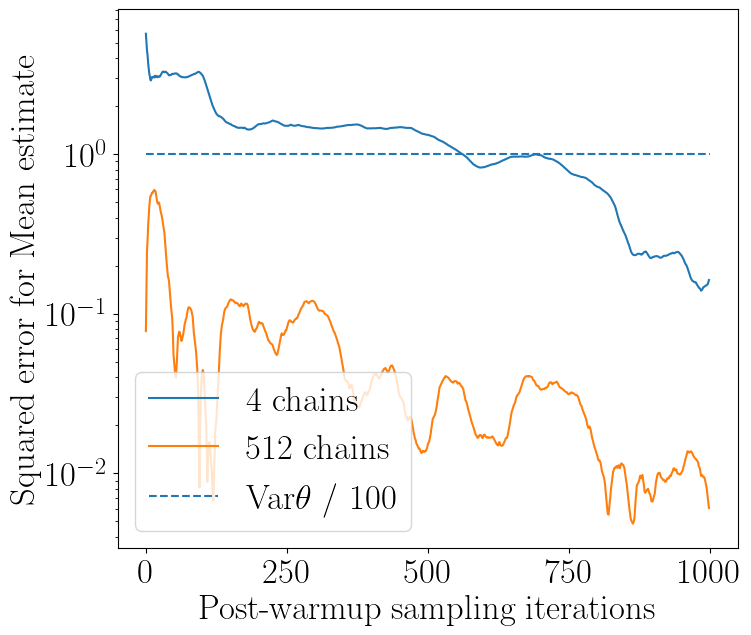

In [20]:
def mc_est_warm(x, axis = 0):
  """ compute running average without discarding half of the samples."""
  return np.cumsum(x, axis) / np.arange(1, x.shape[0] + 1).reshape([-1] + [1] * (len(x.shape) - 1))

discard_warmup = True

if (discard_warmup):
  long_error = mc_est_warm(result_state_long[num_warmup_long:, :, :].mean(1)) - mean_est
  short_error = mc_est_warm(result_state_short[num_warmup_short:, :, :].mean(1)) - mean_est
else:
  long_error = result_state_long[num_warmup_long:, :, :].mean(1) - mean_est
  short_error = result_state_short[num_warmup_short:, :, :].mean(1) - mean_est

true_var_available = True
if (true_var_available):
  target_precision = jnp.linalg.norm(var_est[0] / 100)
else:
  target_precision = jnp.linalg.norm(long_error[len(long_error) - 1], axis = -1)

figure(figsize = [8, 7])
semilogy(jnp.linalg.norm(long_error, axis = -1), label = '4 chains')
semilogy(jnp.linalg.norm(short_error, axis = -1), label = '512 chains')
hlines(target_precision, 0, num_sampling_long,
       linestyles = '--',
       label = r"Var$\theta$ / 100")
ylabel("Squared error for Mean estimate")
xlabel("Post-warmup sampling iterations")
legend(loc = 'lower left')
# show()
plt.savefig("squared_error.pdf", bbox_inches='tight')
# files.download("squared_error.pdf")

In [21]:
def compute_rhat(result_state, num_samples, num_warmup = 0):
  return tfp.mcmc.potential_scale_reduction(result_state[num_warmup:num_warmup + num_samples + 1],
                                          independent_chain_ndims = 1).T

# TODO: do this without a for loop
# WARNING: this cell takes a minute to run
# TODO: use a single variable num_sampling, instead of num_sampling_long and
# num_sampling_var.
rhat_long = np.array([])
rhat_short = np.array([])
range_iter = range(2, num_sampling_long, 10) # range(2, num_samples, 8)

# NOTE: depending on the problem, it can be interesting to look at both.
# However, to be consistent with earlier analysis, the warmup samples should
# be discarded.
discard_warmup = True

for i in range_iter:
  if (discard_warmup):
    discard_long = num_warmup_long
    discard_short = num_warmup_short
  else:
    discard_long = 0
    discard_short = 0
  rhat_long = np.append(rhat_long,
                        compute_rhat(result_state_long, i, discard_long)[0, ])
  rhat_short = np.append(rhat_short,
                          compute_rhat(result_state_short, i, discard_short)[0, ])

In [22]:
result_snip = result_state_long[num_warmup_long:num_warmup_long + 2]
tfp.mcmc.potential_scale_reduction(result_snip, independent_chain_ndims = 1).T

Array([17.449299 , 15.3645735], dtype=float32)

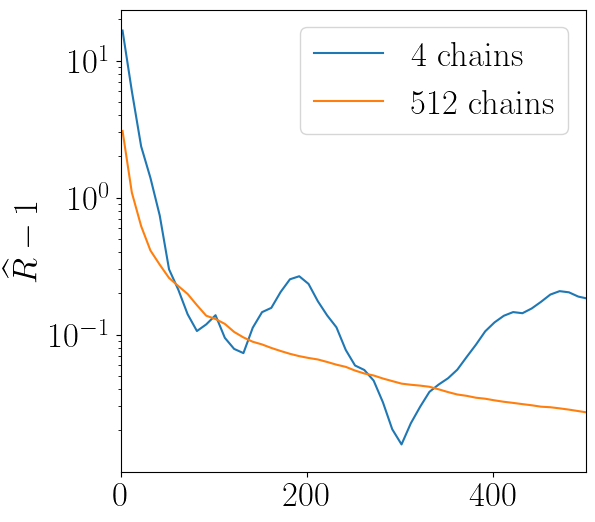

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot result
figure(figsize = [6, 6])
semilogy(np.array(range_iter), rhat_long - 1, label = '4 chains')
semilogy(np.array(range_iter), rhat_short - 1, label = '512 chains')
legend(loc = 'best')
xlim([0, 500])
ylabel("$\widehat R- 1$")
show()
plt.savefig("Rhat_over_iter.pdf")
# files.download("Rhat_over_iter.pdf")

In [26]:
item_index = np.where(jnp.linalg.norm(short_error, axis = -1) <= target_precision)
target_iter_mean = item_index[0][0]
print("Reasonable precision for mean reached in", target_iter_mean + 1, "iteration(s).")

Reasonable precision for mean reached in 1 iteration(s).


In [27]:
index = np.where(range_iter > target_iter_mean)[0][0]
print("Rhat for short regime after hitting target precision:", rhat_short[index])
print("Rhat for long regime after hitting target precision:", rhat_long[len(rhat_long) - 1])

Rhat for short regime after hitting target precision: 4.066953182220459
Rhat for long regime after hitting target precision: 1.3209283351898193


In [34]:
import tensorflow as tf
tf.executing_eagerly()

True

In [35]:
def _axis_size(x, axis = None):
  """Get number of elements of `x` in `axis`, as type `x.dtype`."""
  if axis is None:
    return ps.cast(ps.size(x), x.dtype)
  return ps.cast(
      ps.reduce_prod(
          ps.gather(ps.shape(x), axis)), x.dtype)

def _reduce_variance(x, axis=None, biased=True, keepdims=False):
  with tf.name_scope('reduce_variance'):
    x = tf.convert_to_tensor(x, name='x')
    mean = tf.reduce_mean(x, axis=axis, keepdims=True)
    biased_var = tf.reduce_mean(
        tf.math.squared_difference(x, mean), axis=axis, keepdims=keepdims)
    if biased:
      return biased_var
    n = _axis_size(x, axis)
    return (n / (n - 1.)) * biased_var

def nested_rhat(result_state, num_super_chain):
  used_samples = result_state.shape[0]
  num_sub_chains = result_state.shape[1] // num_super_chains
  num_dimensions = result_state.shape[2]

  chain_states = result_state.reshape(used_samples, -1, num_sub_chains,
                                      num_dimensions)

  state = tf.convert_to_tensor(chain_states, name = 'state')
  mean_chain = tf.reduce_mean(state, axis = 0)
  mean_super_chain = tf.reduce_mean(state, axis = [0, 2])
  variance_chain = _reduce_variance(state, axis = 0, biased = False)
  variance_super_chain = _reduce_variance(mean_chain, axis = 1, biased = False) \
     + tf.reduce_mean(variance_chain, axis = 1)

  W = tf.reduce_mean(variance_super_chain, axis = 0)
  B = _reduce_variance(mean_super_chain, axis = 0, biased = False)

  return tf.sqrt((W + B) / W)


In [36]:
nested_rhat_short = np.array([])
for i in range_iter:
    nested_rhat_short = np.append(nested_rhat_short,
                                  nested_rhat(result_short.all_states[num_warmup_short:num_warmup_short + i, :, :],
                                              num_super_chains).numpy()[0])

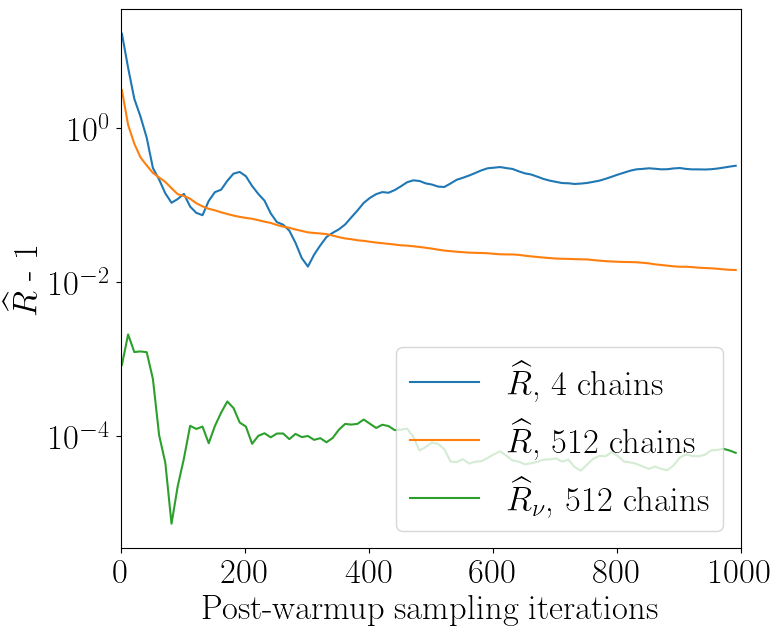

In [38]:
plt.figure(figsize = [8, 7])
plt.semilogy(np.array(range_iter), rhat_long - 1, label = '$\\widehat{R}$, 4 chains')
plt.semilogy(np.array(range_iter), rhat_short - 1, label = '$\\widehat{R}$, 512 chains')
plt.semilogy(np.array(range_iter), nested_rhat_short - 1, label = '$\widehat R_\\nu$, 512 chains')
plt.legend(loc = 'lower right')
plt.xlim([0, 1000])
plt.ylabel("$\widehat R$ - 1")
plt.xlabel("Post-warmup sampling iterations")
#show()
plt.savefig("nRhat_over_iter.pdf", bbox_inches='tight')